<a href="https://colab.research.google.com/github/akamojo/QRS-Detector/blob/master/QRSdetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second assignment part 2

**Student**: António Coelho - MAEBD - 54575 <br>
**Student**: Urszula Barbara Walińska - MIEI - 56556 <br>
**Teacher**: Rui Rodrigues <br>
**Course**: Aprendizagem com dados não estruturados <br>
**Date of delivery**: 07/06/2019

The objetive of this work is to construct a suitable Neural Network in order to preview the QRS spikes based on ECG (electrocardiogram) signals.    
  
To do this is what we will:  
  1.  Prepocessing signals from "incartdb" database.
  2.  Train the network with the prepocessed signals
  3.  Test the network with "mitdb" database.

## install wfdb

In [7]:
!pip install wfdb

# 1. Pre-pocessing signals from "incartdb" database.  


## 1.1 Download the files
In order to download the files:
  - Get the record names list
  - Download all the files to the data folder.

In [0]:
import wfdb
import os
import pandas as pd
from wfdb import io, plot,processing
import numpy as np

record_names = io.get_record_list('incartdb')
data_folder = 'data'
io.dl_database('incartdb', data_folder, record_names)

**Reading one file**

In [3]:
record_name = record_names[0]
record = wfdb.rdrecord('data/' + record_name, channels=[1,6])

print(record.p_signal)
print(record.p_signal.shape)
print(record.sig_name)
print(record.comments)

[[ 1.49346405 -3.4379085 ]
 [ 1.47712418 -3.45098039]
 [ 1.49673203 -3.45424837]
 ...
 [ 4.60784314 -0.16666667]
 [ 4.59150327 -0.17973856]
 [ 4.57189542 -0.11437908]]
(462600, 2)
['II', 'V1']
['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension', 'patient 1', 'PVCs, noise']


## 1.2 Check the frequency and printing the two signals that will be used.
Wfdb.rdsamp() returns a list of two dictionaries, in the second dictionary there is a key called "fs" that represents the frequency of the signal. This information will be used to compare the sampling frequency of the train and test dataset to check if the frequency is the same. If not we will change the frequency of the test the data in order to match the frequency of the training data.

In [4]:
#sample frequency
rddssamp = wfdb.rdsamp(os.path.join('data',record_name))
fs = rddssamp[1]['fs']

print(fs)

257


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt

Plot of two signals from 2 channels that we are going to use to train the neural network. # not really?

ECG shape:  (2, 462600)


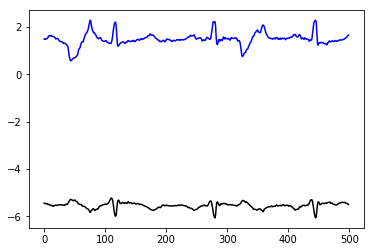

In [6]:
ecg = np.transpose(record.p_signal)
ecg = ecg.astype(np.float32)
print('ECG shape: ', ecg.shape)
t = range(500)
plt.plot(t,ecg[0,t],'b',t,ecg[1,t]-2,'k')
plt.show()

## 1.3 Moving average filter  
  We will use this to to level all the baselines of the ECG signal at a relatively close value.  
    **How it works:**
  -  Calculate the moving average
    -   The moving average is the signal where each position corresponds to the average value of the subset of values between $[t,t+m]$ where $m$ is the length of the desire subset (window).
    -   In this case was defined as 1s and in order to generate the moving average signal we used the function np.convolve() which receives as parameters the original signal and a vector with the all the $m$s desired. In this case we used the same value to calculate the moving average. As the wanted $m= 1s$ this implies that $m= period$ and as $period= \frac{1}{frequency}$ $m = \frac{1}{frequencie}$
  - Subtract the moving average to the signal
    -  After the calculation of the vector with the moving average signal to the original signal(Blue) it was subtract the moving average signal(Black) and we obtain the new signal(red) that is all leveled and in this way the neural network will not need to deal with the moving of the baselines and can " concentrate " to deal with the spikes which is our objective

In [0]:
def normalize(signal, window):
    avg_mask = np.ones(window) / window
    y_avg = np.convolve(signal, avg_mask, 'same')
    return signal - y_avg

257


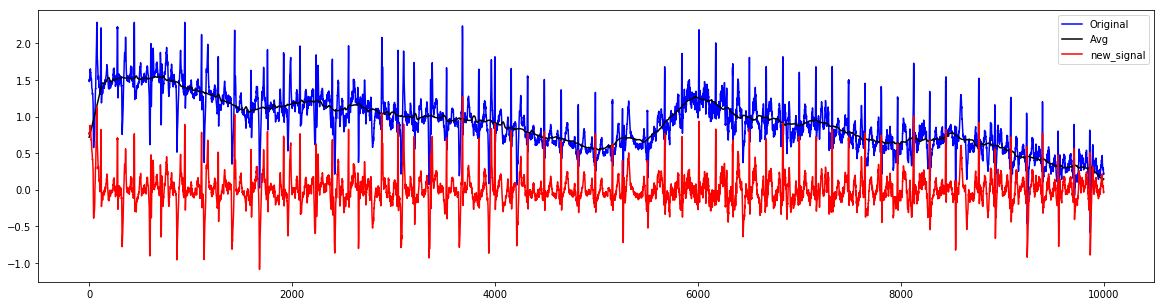

In [8]:
x = range(10000)
y = ecg[0, x]
window = fs 
print(window)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x, ecg[0, x], 'b', label="Original")

avg_mask = np.ones(window) / window
y_avg = np.convolve(y, avg_mask, 'same')

ax.plot(x, y_avg[x], 'k', label="Avg")

new_signal = normalize(ecg[0], window)
ax.plot(x, new_signal[x],'r', label="new_signal")

ax.legend()
plt.show() # still some 'hills'

## 1.4 Load and processing the target QRS positions
QRS is a charactheristc spike of the ECG signal, in this case those locations are identified in the annotations of the record.  
  -  To access them it will be used the function wfdb.rdann() on the files where all the annoations correspond to QRS signals. To do this we will compare all the set of values in the annoations with the vector qrsAnnot which as all the symbols corresponding to qrs signal moments.  
  -  Then with this vector with the positions of the QRS moments there will be used the function parabola which tries to reproduce a signal with spikes in the qrs moments.  
It is possible to see the result in the following graphic


In [0]:
def parabola(a, n, r):
    assert n>2*r
    
    y = np.zeros(n, dtype = np.float32)
    x = np.array(range(2,2*r+1))
    
    for i in a:
        if i > r-1 and i <= n-r:
            y[i-r+1:i+r] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
        elif i < r:
            y[:i+r] = ((r+1)**2-(x[r-i-1:]-r-1)**2)/(r+1)**2
        elif i<n:
            y[i-r+1:] = ((r+1)**2-(x[:r-1+(n-i)]-r-1)**2)/(r+1)**2
    return y

In [10]:
from tqdm import tqdm_notebook as tqdm

# possible symbols
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

data = []
window = fs

for record_name in tqdm(record_names):
    ann = wfdb.rdann(os.path.join('data', record_name), 'atr')
    
    annot_symbols = ann.symbol
    annot_sample = ann.sample
    record_target = []
    
    for i in range(len(annot_symbols)):
        if annot_symbols[i] in qrsAnnot:
            record_target.append(annot_sample[i])

    record = io.rdrecord(record_name=os.path.join('data', record_name), channels=[1, 6])
    
    try:
        new_target = parabola(record_target, len(record.p_signal), 5) #.reshape(1, len(record.p_signal))
        # record_data = np.concatenate((np.transpose(record.p_signal), target), axis = 0)
        
        new_signal = np.transpose(record.p_signal)[0]
        new_signal = normalize(new_signal, window)
        
        record_data = np.array([new_signal, new_target])
        data.append(record_data)
        
    except ValueError:    # why??? :c
        print('skipping..', record_name)
    
    
data = np.array(data)
print(data.shape)

skipping.. I04
skipping.. I17
skipping.. I35
skipping.. I44
skipping.. I57
skipping.. I72
skipping.. I74

(68, 2, 462600)


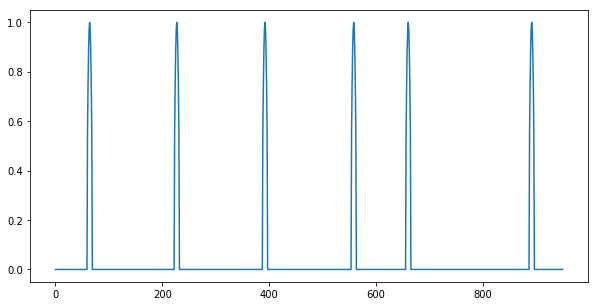

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(data[0, 1, 50:1000])
plt.show()

#2. Train the network with the prepocessed signals



## 2.1 Splitting the signal into train, validation and test data.  
  -  In order to split the signals into train train dataset the function selectFromData was created. It selects random parts of the data in order to train the Neural Newtork

In [0]:
from random import randint

def selectFromData(ecgBdata, seqL, ninputs):
    segmentL  = seqL * ninputs
    numChan = 2
    inpOutSegment = tf.random_crop(ecgBdata[randint(0, ecgBdata.shape[0]), :, :],[numChan, segmentL])
    inputs = inpOutSegment[0,:]
    target = inpOutSegment[1,:]
    return inputs,target


Now we  divide the ECG data in three parts: 
  - Train sub-dataset.
  - Validation sub-dataset.
  

A tensorflow 'Dataset' can be used to represent an input pipeline as a collection of elements (nested structures of tensors) and a "logical plan" of transformations that act on those elements.

In [0]:
N = data.shape[2]
seqL = 20
fs = 257
ninputs = int(0.2 * fs)

# training data
trainData = tf.data.Dataset.from_tensors(data[:, :, :2*N//3])
trainData = trainData.map(lambda x:  selectFromData(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
batchSize = 8
trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(data[:, :, 2*N//3+1:])
valData = valData.map(lambda x:  selectFromData(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
batchSize = 8
valData = valData.batch(batchSize)

Let´s check the input and the target of the train dataset

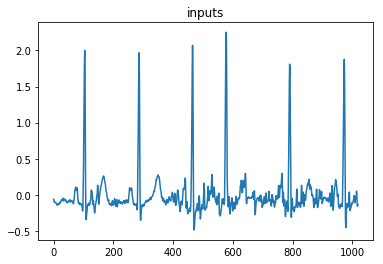

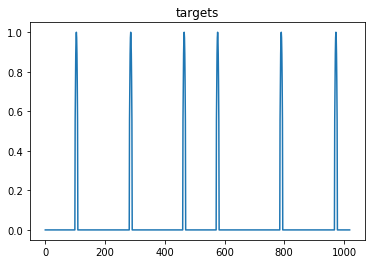

In [21]:
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
plt.plot(inp[0,:])
plt.title('inputs')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

## 2.2 Training with a FeedFoward Neural Network. (Multilayer Perceptron model)
In order to have a term of comparison of the recurrent neural network there was trained a FeedFoward Neural Network.


In [22]:
ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(256, activation='relu',input_shape=(seqL*ninputs,)))
ffwdModel.add(layers.Dense(256, activation='relu'))
ffwdModel.add(layers.Dense(256, activation='relu'))
ffwdModel.add(layers.Dense(seqL*ninputs))

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData,  epochs=50, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Epoch 1/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0296 - mean_absolute_error: 0.0850 - val_loss: 0.0338 - val_mean_absolute_error: 0.0954
Epoch 2/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0198 - mean_absolute_error: 0.0861 - val_loss: 0.0319 - val_mean_absolute_error: 0.0970
Epoch 3/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0163 - mean_absolute_error: 0.0811 - val_loss: 0.0301 - val_mean_absolute_error: 0.0942
Epoch 4/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0756 - val_loss: 0.0284 - val_mean_absolute_error: 0.0915
Epoch 5/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0125 - mean_absolute_error: 0.0706 - val_loss: 0.0263 - val_mean_absolute_error: 0.0858
Epoch 6/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0112 - mean_absolute_error: 0.0663 - val_loss: 0.0248 - val_mean_absolute_error: 0.0801
Epoc

Now let's try to see how did it go. To do this we will evaluate our Feedfoward model with the test data

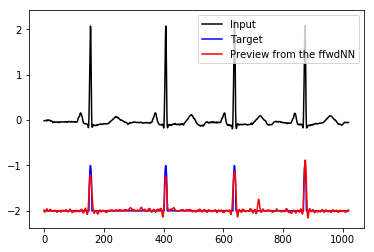

In [23]:
# ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
# out = ffwdModel.evaluate(testData, steps=500)
# print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])

iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'b',t,output[0]-2,'r')
plt.legend(["Input","Target","Preview from the ffwdNN"])
plt.show()

// now it's perfect because it's on test data xd <br>
As we can see the output of the neural network, the red line, does not present very good results comparing with the target, the blue line. This was more or less expected because feedfoward neural networks are not very good with sequences once the weights of previous inputs are not taked into account in the weights of the next inputs.

## 2.3 Recurrent model
The recurrent Neural Network is a network where the weights of the inputs are taked into account in the weights of the next inputs.  
Matematically speaking is based on composed functions:  
If we use the gradient descent the update of the function will be the gradient of the activation function of the weights times the inputs plus the previous weights times the previous inputs plus a bias:  
$$ new\_weights = previous\_weight + learning\_rate*\nabla f(X_t*W_k +X_{t-1}*W_{k-1}+bias)$$  

Note: it is important to understand that the term $W_{k-1}$ can be a composed function based ont the input $X_{k-2}$ and so on.

In our case we used the Root Mean Square Propagation Optimizer the ideia is similiar but the RMSPropOptimizer calculates the stepsize like in momentum algorithm, it takes into account how close the value is to the optimal and adjust stepsize in order to do not pass the optimal point, it also tries to prevent useless variances caused by some input outliers in order to converge faster.

In [24]:
numLstmUnits = 32
denseDim = ninputs
rnnModel = tf.keras.Sequential()
rnnModel.add(layers.Reshape((seqL,ninputs), input_shape=(seqL*ninputs,)))
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))         
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.TimeDistributed(layers.Dense(denseDim)))
rnnModel.add(layers.Reshape((seqL*ninputs,)))

rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
rnnModel.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Epoch 1/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0130 - mean_absolute_error: 0.0462 - val_loss: 0.0173 - val_mean_absolute_error: 0.0545
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0020 - mean_absolute_error: 0.0192 - val_loss: 0.0161 - val_mean_absolute_error: 0.0477
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0161 - val_loss: 0.0155 - val_mean_absolute_error: 0.0457
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0146 - val_loss: 0.0147 - val_mean_absolute_error: 0.0423
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0133 - val_loss: 0.0148 - val_mean_absolute_error: 0.0415
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0126 - val_loss: 0.0145 - val_mean_absolute_error: 0.0401
Epoc

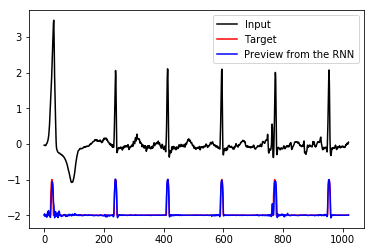

In [25]:
# rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
# out = rnnModel.evaluate(testData, steps=500)
# print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])

iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = rnnModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.legend(["Input","Target","Preview from the RNN"])
plt.show()

# 3. Loading the test data
To test if the Recursive Neural Network trained can adapt to real situations there was used the mitbih Arrhythmia dataset.

## 3.1 Download the data  
As it was made before the data was dowloaded to test_data folder.

In [0]:
record_names_test = io.get_record_list('mitdb')
data_folder = 'test_data'
io.dl_database('mitdb', data_folder, record_names_test)

In [27]:
record_name = record_names_test[0]
record = wfdb.rdrecord('test_data/' + record_name)

print(record.p_signal)
print(record.p_signal.shape)
print(record.sig_name)
print(record.comments)

[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]
(650000, 2)
['MLII', 'V5']
['69 M 1085 1629 x1', 'Aldomet, Inderal']


## 3.2 Frequency correction of the signal
In order to use our desinged Recursive Neural Network the frequency was corrected to 257 Hz

In [28]:
rddssamp = wfdb.rdsamp(os.path.join('test_data', record_name))
fs = rddssamp[1]['fs']
print(fs)

#changing the frequency from 360 to 257
fs_target = 257
new_sample = wfdb.processing.resample_sig(np.transpose(record.p_signal)[0], fs, fs_target)
print(new_sample[0].shape)

360
(464027,)


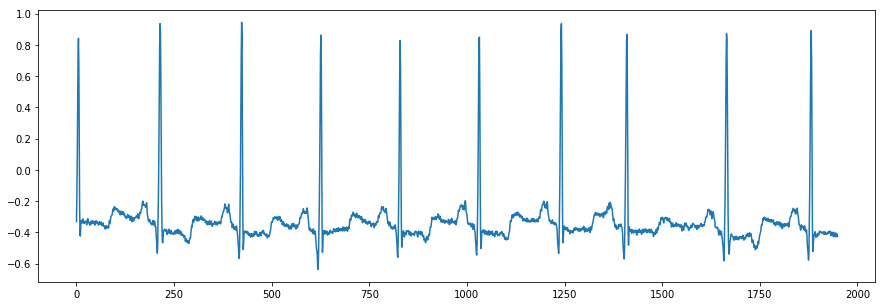

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(new_sample[0][50:2000])
plt.show()

**Reading test dataset**

In [30]:
from tqdm import tqdm_notebook as tqdm

# possible symbols
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

test_data = []
fs_target = 257
window = fs_target

for record_name in tqdm(record_names_test):
    rddssamp = wfdb.rdsamp(os.path.join('test_data', record_name))
    fs = rddssamp[1]['fs']
    
    ann = wfdb.rdann(os.path.join('test_data', record_name), 'atr')
    record = io.rdrecord(record_name=os.path.join('test_data', record_name))
    new_signal, new_ann = wfdb.processing.resample_multichan(record.p_signal, ann, fs, fs_target)
    new_signal = np.transpose(new_signal)[0]
    
    annot_symbols = new_ann.symbol
    annot_sample = new_ann.sample
    
    record_target = []
    
    for i in range(len(annot_symbols)):
        if annot_symbols[i] in qrsAnnot:
            record_target.append(annot_sample[i])
            
    target = parabola(record_target, new_signal.shape[0], 5)
    new_signal = normalize(new_signal, window)
    record_data = np.array([new_signal, target])
    
    test_data.append(record_data)
    
    
test_data = np.array(test_data)
print(test_data.shape)


(48, 2, 464027)


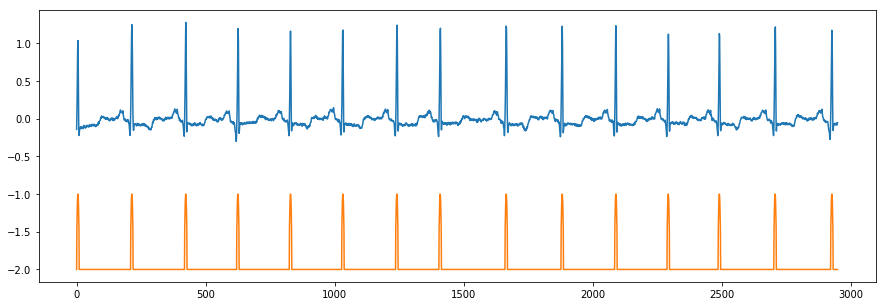

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(test_data[0][0, 50:3000])
plt.plot(test_data[0][1, 50:3000] - 2)
plt.show()

In [0]:
seqL = 20
fs = 257
ninputs = int(0.2 * fs)

# test data
testData = tf.data.Dataset.from_tensors(test_data)
testData = testData.map(lambda x:  selectFromData(x, seqL, ninputs))
#testData = testData.map(lambda x:  selectFromtest_Data(x))#,seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData = testData.batch(batchSize)

In [0]:
def local_peaks(output, threshold):
    output[0][output[0] < threshold] = 0
#     print(output[0][output[0] > 0])
    p = wfdb.processing.find_local_peaks(output[0], int(0.12*257))
#     print(output[0][p])
    aux = np.nonzero(output[0][p])
    return p[aux]

## 3.3 Evaluation of the FeedFoward Neural Network

500/500 [==============================] - 5s 11ms/step - loss: 0.0370 - mean_absolute_error: 0.0874
test mean square error (loss):  0.03701268822699785   test absolute error:  0.0874472


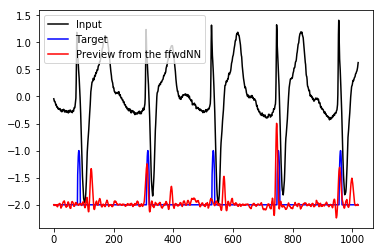

In [43]:
ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = ffwdModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])

iterator = testData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'b',t,output[0]-2,'r')
plt.legend(["Input","Target","Preview from the ffwdNN"])
plt.show()

In [44]:
local_peaks(output, 0.5)

array([125, 312, 570, 746, 957])

## 3.4 Evaluation of the Recursive Neural Network

500/500 [==============================] - 6s 12ms/step - loss: 0.0192 - mean_absolute_error: 0.0570
test mean square error (loss):  0.01920720601826906   test absolute error:  0.056986745


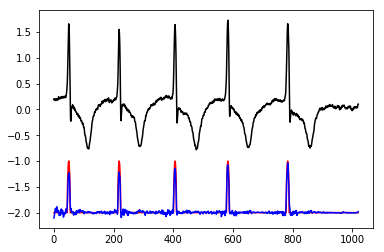

In [45]:
rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = rnnModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])

iterator = testData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = rnnModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()

In [46]:
local_peaks(output, 0.5)

array([ 50, 218, 405, 582, 783])

In [0]:

def selectFromtest_Data(ecgBdata):
    inputs = tf.tensor(np.transpose(ecgBdata[:,0,:]))
    target = tf.tensor(np.transpose(ecgBdata[:,1,:]))
    #segmentL  = seqL * ninputs
    #numChan = 2
    #inpOutSegment = tf.random_crop(ecgBdata[randint(0, ecgBdata.shape[0]), :, :],[numChan, segmentL])
    #inputs = inpOutSegment[0,:]
    #target = inpOutSegment[1,:]
    return inputs,target

In [0]:
rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = rnnModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = testData.make_initializable_iterator()
next_element = iterator.get_next()

while True:
    try:
        with tf.Session() as sess:
            sess.run(iterator.initializer)
            inp, targ = sess.run(next_element)
        
        output = rnnModel.predict(inp)

        t = range(seqL*ninputs)
        plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
        plt.show()
        
        next_element = iterator.get_next()

    except ValueError:
        break 

In [0]:
seqL = 20
fs = 257
ninputs = int(0.2*fs)

# test data
testData =tf.data.Dataset.from_tensors(test_data)
testData = testData.map(lambda x:  selectFromtest_Data(x))
testData = testData.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData = testData.batch(batchSize)

In [0]:
rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = rnnModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = testData.make_initializable_iterator()
next_element = iterator.get_next()

peaks = []

while True:
    try:
        with tf.Session() as sess:
            sess.run(iterator.initializer)
            inp, targ = sess.run(next_element)
        
        output = rnnModel.predict(inp)
        peaks.append(local_peaks(output))# check the offset of each line
        
        next_element = iterator.get_next()
        print('next')

    except ValueError:
        break 

ValueError: ignored

## 4. Conclusion
In the end the Recursive Neural Networks give better results when processing signals which was expectable once signals tend to have a patterns based on time, or in other words they tend to follow a sequence. Once Recursive Neural Networks take as an input also the input from previous timestamp, they are able to take, in a certain way, this into account.  
With this work it is also possible to say that it is feasible to construct a Recursive Neural network to predict when QRS signals will appear.  